### read data

In [2]:
model_data = pd.read_csv('../data/curated/model-data/model-data.csv', index_col=0)

# Read xlsx file into DataFrame df
xls = pd.ExcelFile('../data/external-raw-data/Quarterly median rents by local government area - March Quarter 2021.xlsx')
# set header
rent_data = pd.read_excel(xls, 'All Properties', header=[2,3])

# Read xlsx file into DataFrame df
xls_convert = pd.ExcelFile('../data/external-raw-data/lga_postcode_table.xlsx')
df_convert = pd.read_excel(xls_convert, 'lga_postcode_mappings')

### convert lga to postcode with past_rent_data

In [3]:
# Preprocessing for rent data file
# Change the Local Government Area column of rent data to UPPER case for merge
rent_data.loc[:, ('Unnamed: 1_level_0', 'Unnamed: 1_level_1')] = rent_data['Unnamed: 1_level_0']['Unnamed: 1_level_1'].str.upper()
# drop first column which is the region column that we do not need
rent_data = rent_data.drop([('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], axis=1)

In [4]:
# convert multi index to simple index
rent_data.columns = rent_data.columns.map('_'.join)
rent_data.rename(columns = {'Unnamed: 1_level_0_Unnamed: 1_level_1':'LGA region'}, inplace = True)

In [5]:
# Only remain the data of Victoria
df_convert = df_convert[df_convert['State'] =='Victoria']
df_convert = df_convert[df_convert['Postcode']< 4000]
df_convert = df_convert[df_convert['Postcode']>= 3000]

# Change the LGA region column of convertion file to UPPER case for merge
df_convert['LGA region'] = df_convert['LGA region'].str.upper().str.strip()

In [6]:
# reset the index and drop the original index column
df_convert = df_convert.reset_index()
df_convert = df_convert.drop(['index'], axis=1)

In [7]:
# make sure LGA region for two dataframe are the same data type
rent_data.loc[:,"LGA region"] = rent_data.loc[:,"LGA region"].astype(str).str.strip()
df_convert.loc[:,"LGA region"] = df_convert.loc[:,"LGA region"].astype(str).str.strip()

# inner join merge by Local Government Area and LGA region
df_merge = df_convert.merge(rent_data, left_on="LGA region", right_on="LGA region", how='inner')

In [8]:
# group by by postcode by median rent of each postcode
past_rent_data = df_merge.groupby(['Postcode']).median().reset_index()

### check with model data and join it

In [9]:
postcode_list = list(model_data['postcode'].unique())

In [10]:
df_filtered = past_rent_data.loc[past_rent_data['Postcode'].isin(postcode_list)]

In [11]:
df_filtered.replace("none", np.nan, inplace=True)

/var/folders/nf/s3hrf4f94bx7d661b9kg76v80000gn/T/ipykernel_24908/3458065859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.replace("none", np.nan, inplace=True)


In [12]:
df_filtered.rename(columns = {'Postcode':'postcode'}, inplace = True)

# selected new columns
column_names_select_external = ['postcode', 'Mar 2018_Median', 'Jun 2018_Median', 'Sep 2018_Median', 'Dec 2018_Median',
                                'Mar 2019_Median', 'Jun 2019_Median', 'Sep 2019_Median', 'Dec 2019_Median',
                                'Mar 2020_Median', 'Jun 2020_Median', 'Sep 2020_Median', 'Dec 2020_Median',
                                'Mar 2021_Median']

df_filtered = df_filtered[column_names_select_external]

/var/folders/nf/s3hrf4f94bx7d661b9kg76v80000gn/T/ipykernel_24908/2546005733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns = {'Postcode':'postcode'}, inplace = True)


In [13]:
# join internal features with external features
model_data = pd.merge(model_data, df_filtered, on='postcode', how='outer')

In [14]:
counts =model_data.isna().sum()

In [15]:
counts

postcode                        0
street                          0
suburb                          0
latitude                        0
longitude                       0
bedrooms                        0
bathrooms                       0
parking                         0
property_type                   0
price                           0
postcode_property_count         0
public-service-duration         0
care-facility-duration          0
shopping-center-duration        0
train-station-duration          0
hospital-duration               0
CBD-duration                    0
emergency-service-duration      0
property-count                  0
elector-count                   0
crime-rate                      0
income                          0
pri-1-10                        0
pri-11-50                       0
pri-51-100                      0
pri-101-150                     0
pri-150+                        0
sec-1-10                        0
sec-11-50                       0
sec-51-100    

### group by postcode

In [22]:
model_data

,postcode,street,suburb,latitude,longitude,bedrooms,bathrooms,parking,property_type,price,...,Dec 2018_Median,Mar 2019_Median,Jun 2019_Median,Sep 2019_Median,Dec 2019_Median,Mar 2020_Median,Jun 2020_Median,Sep 2020_Median,Dec 2020_Median,Mar 2021_Median
0,3029,33 cindia crescent,TARNEIT,-37.836800,144.681992,3,2,2,House,410.0,...,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0
1,3029,3 loire close,HOPPERS CROSSING,-37.858776,144.670990,4,2,2,House,420.0,...,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0
2,3029,5 toscana,TRUGANINA,-37.831726,144.721200,4,2,2,New House & Land,440.0,...,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0
3,3029,12 sussex court,TARNEIT,-37.850758,144.712234,3,3,1,House,415.0,...,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0
4,3029,4a craig close,TRUGANINA,-37.843980,144.717514,3,2,1,House,410.0,...,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12122,3934,15/26 green island avenue,MOUNT MARTHA,-38.248100,145.041611,3,2,2,Townhouse,625.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12123,3934,8 raymond street,MOUNT MARTHA,-38.285440,144.995331,4,2,2,House,720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12124,3934,15 whitsunday ct,MOUNT MARTHA,-38.250070,145.052078,4,2,2,House,700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12125,3934,107 forest dr,MOUNT MARTHA,-38.290226,145.016418,3,2,2,House,870.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
model_data.to_csv("../data/curated/model-data/model-data-with-rent.csv")

### Data processing — transform raw data to time series with Time being the index

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_data = pd.read_csv('../data/curated/model-data/model-data-with-rent.csv', index_col=0)

In [3]:
df1 = model_data.groupby('postcode').median()
df2 = pd.DataFrame(data = df1['price'])
model_data = pd.merge(model_data, df2, on='postcode', how='outer')
model_data.to_csv("../data/curated/model-data/model-data-with-med-rent.csv")

In [1]:
import pandas as pd
import numpy as np


# import required libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, isnan, when, count, mean, udf, split, unix_timestamp, from_unixtime
from pyspark.sql.types import StringType, IntegerType, FloatType

# init SparkSession class
spark = (
    # if available consider use yarn master node
    SparkSession.builder.master("local[*]") 
    
    # spark executor env configuration
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.cores", "2")
    .config("spark.executor.instances", "6")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    
    # jvm memory configuration
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "8g")
    
    # parquet file load configuration
    .config("spark.sql.repl.eagerEval.enabled", 'true')
    .config("spark.sql.parquet.cacheMetadata", 'true')
    
    # build the session
    .appName("Pyspark Start Template") # change app name here
    .getOrCreate()
)

# change default log level
spark.sparkContext.setLogLevel('ERROR')

import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 00:59:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/03 00:59:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/03 00:59:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
model_data = spark.read.csv('../data/curated/model-data/model-data-with-med-rent.csv', header=True)
model_data.limit(5)

_c0,postcode,street,suburb,latitude,longitude,bedrooms,bathrooms,parking,property_type,price_x,postcode_property_count,public-service-duration,care-facility-duration,shopping-center-duration,train-station-duration,hospital-duration,CBD-duration,emergency-service-duration,property-count,elector-count,crime-rate,income,pri-1-10,pri-11-50,pri-51-100,pri-101-150,pri-150+,sec-1-10,sec-11-50,sec-51-100,sec-101-150,sec-150+,population-growth-rate,Mar 2018_Median,Jun 2018_Median,Sep 2018_Median,Dec 2018_Median,Mar 2019_Median,Jun 2019_Median,Sep 2019_Median,Dec 2019_Median,Mar 2020_Median,Jun 2020_Median,Sep 2020_Median,Dec 2020_Median,Mar 2021_Median,price_y
0,3029,33 cindia crescent,TARNEIT,-37.8368,144.681992,3,2,2,House,410.0,264,3.6116666666666655,3.1865,6.2465,16.598,18.726666666666667,29.896666666666665,4.91,36165.0,58363.0,4668.504451099,1402.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.1296719148291511,360.0,360.0,370.0,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0,420.0
1,3029,3 loire close,HOPPERS CROSSING,-37.8587761,144.67099,4,2,2,House,420.0,264,3.6116666666666655,3.1865,6.2465,16.598,18.726666666666667,29.896666666666665,4.91,36165.0,58363.0,4668.504451099,1402.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.0354299436980701,360.0,360.0,370.0,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0,420.0
2,3029,5 toscana,TRUGANINA,-37.8317261,144.7212,4,2,2,New House & Land,440.0,264,3.6116666666666655,3.1865,6.2465,16.598,18.726666666666667,29.896666666666665,4.91,36165.0,58363.0,4668.504451099,1402.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.1296719148291511,360.0,360.0,370.0,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0,420.0
3,3029,12 sussex court,TARNEIT,-37.8507576,144.712234,3,3,1,House,415.0,264,3.6116666666666655,3.1865,6.2465,16.598,18.726666666666667,29.896666666666665,4.91,36165.0,58363.0,4668.504451099,1402.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.1296719148291511,360.0,360.0,370.0,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0,420.0
4,3029,4a craig close,TRUGANINA,-37.84398,144.717514,3,2,1,House,410.0,264,3.6116666666666655,3.1865,6.2465,16.598,18.726666666666667,29.896666666666665,4.91,36165.0,58363.0,4668.504451099,1402.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.1296719148291511,360.0,360.0,370.0,370.0,370.0,370.0,370.0,380.0,375.0,370.0,370.0,370.0,370.0,420.0


In [3]:
agg = model_data.groupBy('postcode').agg(
                                        F.mean('Mar 2018_Median').alias('2018-3'),
                                        F.mean('Jun 2018_Median').alias('2018-6'),
                                        F.mean('Sep 2018_Median').alias('2018-9'),
                                        F.mean('Dec 2018_Median').alias('2018-12'),
                                        F.mean('Mar 2019_Median').alias('2019-3'),
                                        F.mean('Jun 2019_Median').alias('2019-6'),
                                        F.mean('Sep 2019_Median').alias('2019-9'),
                                        F.mean('Dec 2019_Median').alias('2019-12'),
                                        F.mean('Mar 2020_Median').alias('2020-3'),
                                        F.mean('Jun 2020_Median').alias('2020-6'),
                                        F.mean('Sep 2020_Median').alias('2020-9'),
                                        F.mean('Dec 2020_Median').alias('2020-12'),
                                        F.mean('Mar 2021_Median').alias('2021'),
                                        F.mean('price_y').alias('2022')
                                                                                    ).orderBy('postcode')

agg = agg.toPandas()
agg = agg.dropna()
agg = agg.set_index('postcode')
agg

,2018-3,2018-6,2018-9,2018-12,2019-3,2019-6,2019-9,2019-12,2020-3,2020-6,2020-9,2020-12,2021,2022
postcode,,,,,,,,,,,,,,
3000,480.0,500.0,480.0,500.0,500.0,510.0,490.0,500.0,490.0,440.0,400.0,380.0,370.0,557.5
3002,490.0,495.0,490.0,507.5,507.5,512.5,492.5,507.5,500.0,465.0,435.0,415.0,410.0,625.0
3003,435.0,450.0,440.0,450.0,450.0,454.0,455.0,450.0,450.0,420.0,395.0,387.5,385.0,500.0
3004,470.0,480.0,470.0,485.0,487.5,495.0,482.5,490.0,485.0,450.0,440.0,425.0,405.0,600.0
3006,470.0,480.0,470.0,485.0,487.5,491.0,475.0,487.5,485.0,445.0,420.0,405.0,390.0,570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,360.0,360.0,360.0,370.0,365.0,360.0,360.0,370.0,375.0,370.0,375.0,380.0,380.0,670.0
3975,365.0,365.0,370.0,370.0,367.5,372.5,370.0,367.5,375.0,372.5,375.0,372.5,377.5,480.0
3976,365.0,365.0,370.0,370.0,367.5,372.5,370.0,367.5,375.0,372.5,375.0,372.5,377.5,420.0


In [4]:
df1 = pd.DataFrame(data = agg['2018-3']).reset_index()
date = '2018-3'
df1['dates'] = date 
df1 = df1.set_index('dates')
df1.rename(columns = {'2018-3':'price'}, inplace = True)

df2 = pd.DataFrame(data = agg['2018-6']).reset_index()
date = '2018-6'
df2['dates'] = date 
df2 = df2.set_index('dates')
df2.rename(columns = {'2018-6':'price'}, inplace = True)

df3 = pd.DataFrame(data = agg['2018-9']).reset_index()
date = '2018-9'
df3['dates'] = date 
df3 = df3.set_index('dates')
df3.rename(columns = {'2018-9':'price'}, inplace = True)

df4 = pd.DataFrame(data = agg['2018-12']).reset_index()
date = '2018-12'
df4['dates'] = date 
df4 = df4.set_index('dates')
df4.rename(columns = {'2018-12':'price'}, inplace = True)

df5 = pd.DataFrame(data = agg['2019-3']).reset_index()
date = '2019-3'
df5['dates'] = date 
df5 = df5.set_index('dates')
df5.rename(columns = {'2019-3':'price'}, inplace = True)

df6 = pd.DataFrame(data = agg['2019-6']).reset_index()
date = '2019-6'
df6['dates'] = date 
df6 = df6.set_index('dates')
df6.rename(columns = {'2019-6':'price'}, inplace = True)

df7 = pd.DataFrame(data = agg['2019-9']).reset_index()
date = '2019-9'
df7['dates'] = date 
df7 = df7.set_index('dates')
df7.rename(columns = {'2019-9':'price'}, inplace = True)

df8 = pd.DataFrame(data = agg['2019-12']).reset_index()
date = '2019-12'
df8['dates'] = date 
df8 = df8.set_index('dates')
df8.rename(columns = {'2019-12':'price'}, inplace = True)

df9 = pd.DataFrame(data = agg['2020-3']).reset_index()
date = '2020-3'
df9['dates'] = date 
df9 = df9.set_index('dates')
df9.rename(columns = {'2020-3':'price'}, inplace = True)

df10 = pd.DataFrame(data = agg['2020-6']).reset_index()
date = '2020-6'
df10['dates'] = date 
df10 = df10.set_index('dates')
df10.rename(columns = {'2020-6':'price'}, inplace = True)

df11 = pd.DataFrame(data = agg['2020-9']).reset_index()
date = '2020-9'
df11['dates'] = date 
df11 = df11.set_index('dates')
df11.rename(columns = {'2020-9':'price'}, inplace = True)

df12 = pd.DataFrame(data = agg['2020-12']).reset_index()
date = '2020-12'
df12['dates'] = date 
df12 = df12.set_index('dates')
df12.rename(columns = {'2020-12':'price'}, inplace = True)

df13 = pd.DataFrame(data = agg['2021']).reset_index()
date = '2021'
df13['dates'] = date 
df13 = df13.set_index('dates')
df13.rename(columns = {'2021':'price'}, inplace = True)

df14 = pd.DataFrame(data = agg['2022']).reset_index()
date = '2022'
df14['dates'] = date 
df14 = df14.set_index('dates')
df14.rename(columns = {'2022':'price'}, inplace = True)

In [5]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])
df

,postcode,price
dates,,
2018-3,3000,480.0
2018-3,3002,490.0
2018-3,3003,435.0
2018-3,3004,470.0
2018-3,3006,470.0
...,...,...
2022,3930,670.0
2022,3975,480.0
2022,3976,420.0


<AxesSubplot:xlabel='dates'>

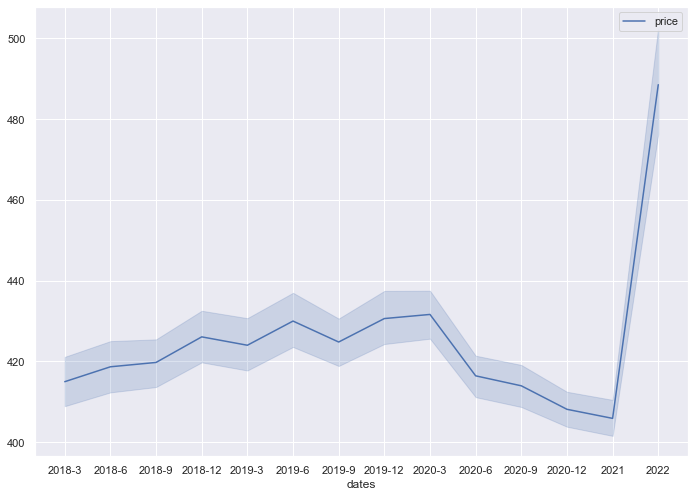

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=df)

In [7]:
df

,postcode,price
dates,,
2018-3,3000,480.0
2018-3,3002,490.0
2018-3,3003,435.0
2018-3,3004,470.0
2018-3,3006,470.0
...,...,...
2022,3930,670.0
2022,3975,480.0
2022,3976,420.0


In [13]:
df.index = pd.to_datetime(df.index)
df

,postcode,price
dates,,
2018-03-01,3000,480.0
2018-03-01,3002,490.0
2018-03-01,3003,435.0
2018-03-01,3004,470.0
2018-03-01,3006,470.0
...,...,...
2018-03-01,3930,360.0
2018-03-01,3975,365.0
2018-03-01,3976,365.0


In [15]:
df1.iplot(title="Energy Production Jan 1985--Jan 2018")

AttributeError: 'DataFrame' object has no attribute 'iplot'

In [14]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='multiplicative')
fig = result.plot()
plot_mpl(fig)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None